# Import Library & Set Globals


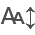

/mnt/DATA/home/ethung/snRNAseq_analysis/.venv/lib/python3.12/site-packages/scvi/__init__.py:31: DeprecationWarning: scvi is deprecated, please uninstall scvi via `pip uninstall scvi` and install the new scvi-tools package at github.com/YosefLab/scvi-tools
/mnt/DATA/home/ethung/snRNAseq_analysis/.venv/lib/python3.12/site-packages/phenograph/cluster.py:13: DeprecationWarning: Please import `spmatrix` from the `scipy.sparse` namespace; the `scipy.sparse.base` namespace is deprecated and will be removed in SciPy 2.0.0.


In [1]:
%load_ext jupyter_black

# base
import os
import pickle
import sys
import warnings
import logging

logging.basicConfig(level="INFO")
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

# data manipulation
import scipy
import itables.options as opt
from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)

# single cell
import scanpy as sc
import decoupler as dc
import liana as li
from pacmap import LocalMAP
import gseapy as gp

# custom
sys.path.append("../..")
from python import *

warnings.simplefilter("ignore", pd.errors.DtypeWarning)
mlogger = logging.getLogger("matplotlib")
mlogger.setLevel(logging.WARNING)

# R
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter

converter = get_converter()
%load_ext rpy2.ipython

In [2]:
%matplotlib inline
study = "paper_processed_FULL"
R_converted = False

CORES = 10
DATADIR = "../../../data"
REFDIR = "../../../references"
DOUBLETMETHODS = ["scDblFinder", "DoubletFinder", "doubletdetection", "scrublet"]

# Get all data

In [3]:
# load
annotation = "manDoublet-seuratV3-harmony-annotated_all_leiden1"
savedir = os.path.join(DATADIR, "processed", study, "py", "3_annotated")
adata = sc.read_h5ad(os.path.join(savedir, f"{annotation}.h5ad"))

# order categories
order_obs(
    adata,
    "Identifier",
    [
        "GSM7747185-LFD_eWAT",
        "GSM7747187-HFD_eWAT",
        "GSM7747186-LFD_iWAT",
        "GSM7747188-HFD_iWAT",
    ],
)
order_obs(
    adata,
    "Groups",
    [
        "GSM7747185-LFD_eWAT",
        "GSM7747187-HFD_eWAT",
        "GSM7747186-LFD_iWAT",
        "GSM7747188-HFD_iWAT",
    ],
)
order_obs(adata, "Experiment", ["GSM7747185", "GSM7747186", "GSM7747187", "GSM7747188"])
order_obs(adata, "Condition", ["LFD", "HFD"])
order_obs(adata, "Sample Type", ["eWAT", "iWAT"])

In [ ]:
# # save
# annotation = "manDoublet-seuratV3-harmony-annotated_leiden1"
# savedir = os.path.join(DATADIR,'processed',study,'py', '3_annotated')
# adata.write(os.path.join(savedir,f'{annotation}.h5ad'))

# Stromal prep

### Create Subset

Index(['Adipocyte', 'Fibroblast', 'Mesothelial', 'Endothelial', 'PC/SMC',
       'Macrophage', 'Dendritic Cell', 'Mast Cell', 'T Cell', 'B Cell'],
      dtype='object')
Starting UMAP...
Starting LocalMAP...


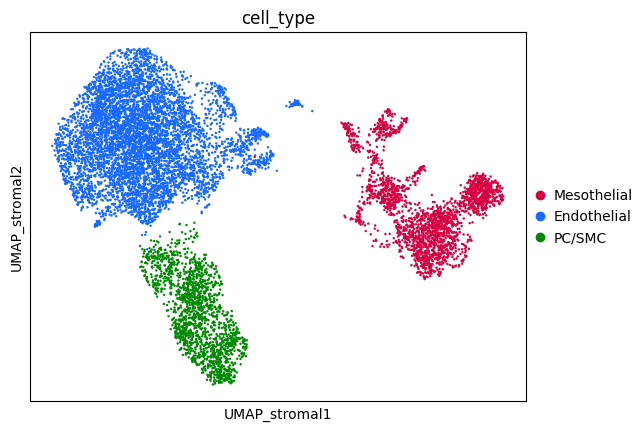

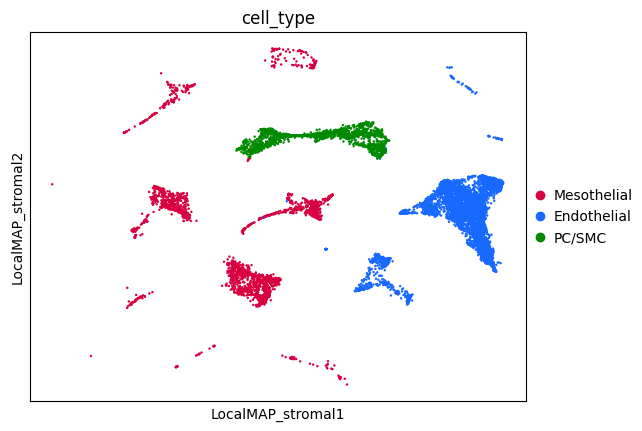

In [4]:
# subset
print(adata.obs["cell_type"].cat.categories)
adata_stromal = adata[
    adata.obs["cell_type"].isin(["Mesothelial", "Endothelial", "PC/SMC"])
].copy()
del adata_stromal.uns, adata_stromal.varm, adata_stromal.obsp
sc.pp.filter_cells(adata_stromal, min_genes=200)
sc.pp.filter_genes(adata_stromal, min_cells=5)
Visualize(adata_stromal, "_stromal")
sc.pl.embedding(
    adata_stromal,
    basis="UMAP_stromal",
    color="cell_type",
    palette=color_gen(adata_stromal.obs["cell_type"]).to_list(),
)
sc.pl.embedding(
    adata_stromal,
    basis="LocalMAP_stromal",
    color="cell_type",
    palette=color_gen(adata_stromal.obs["cell_type"]).to_list(),
)

Category Groups has 4 groups!


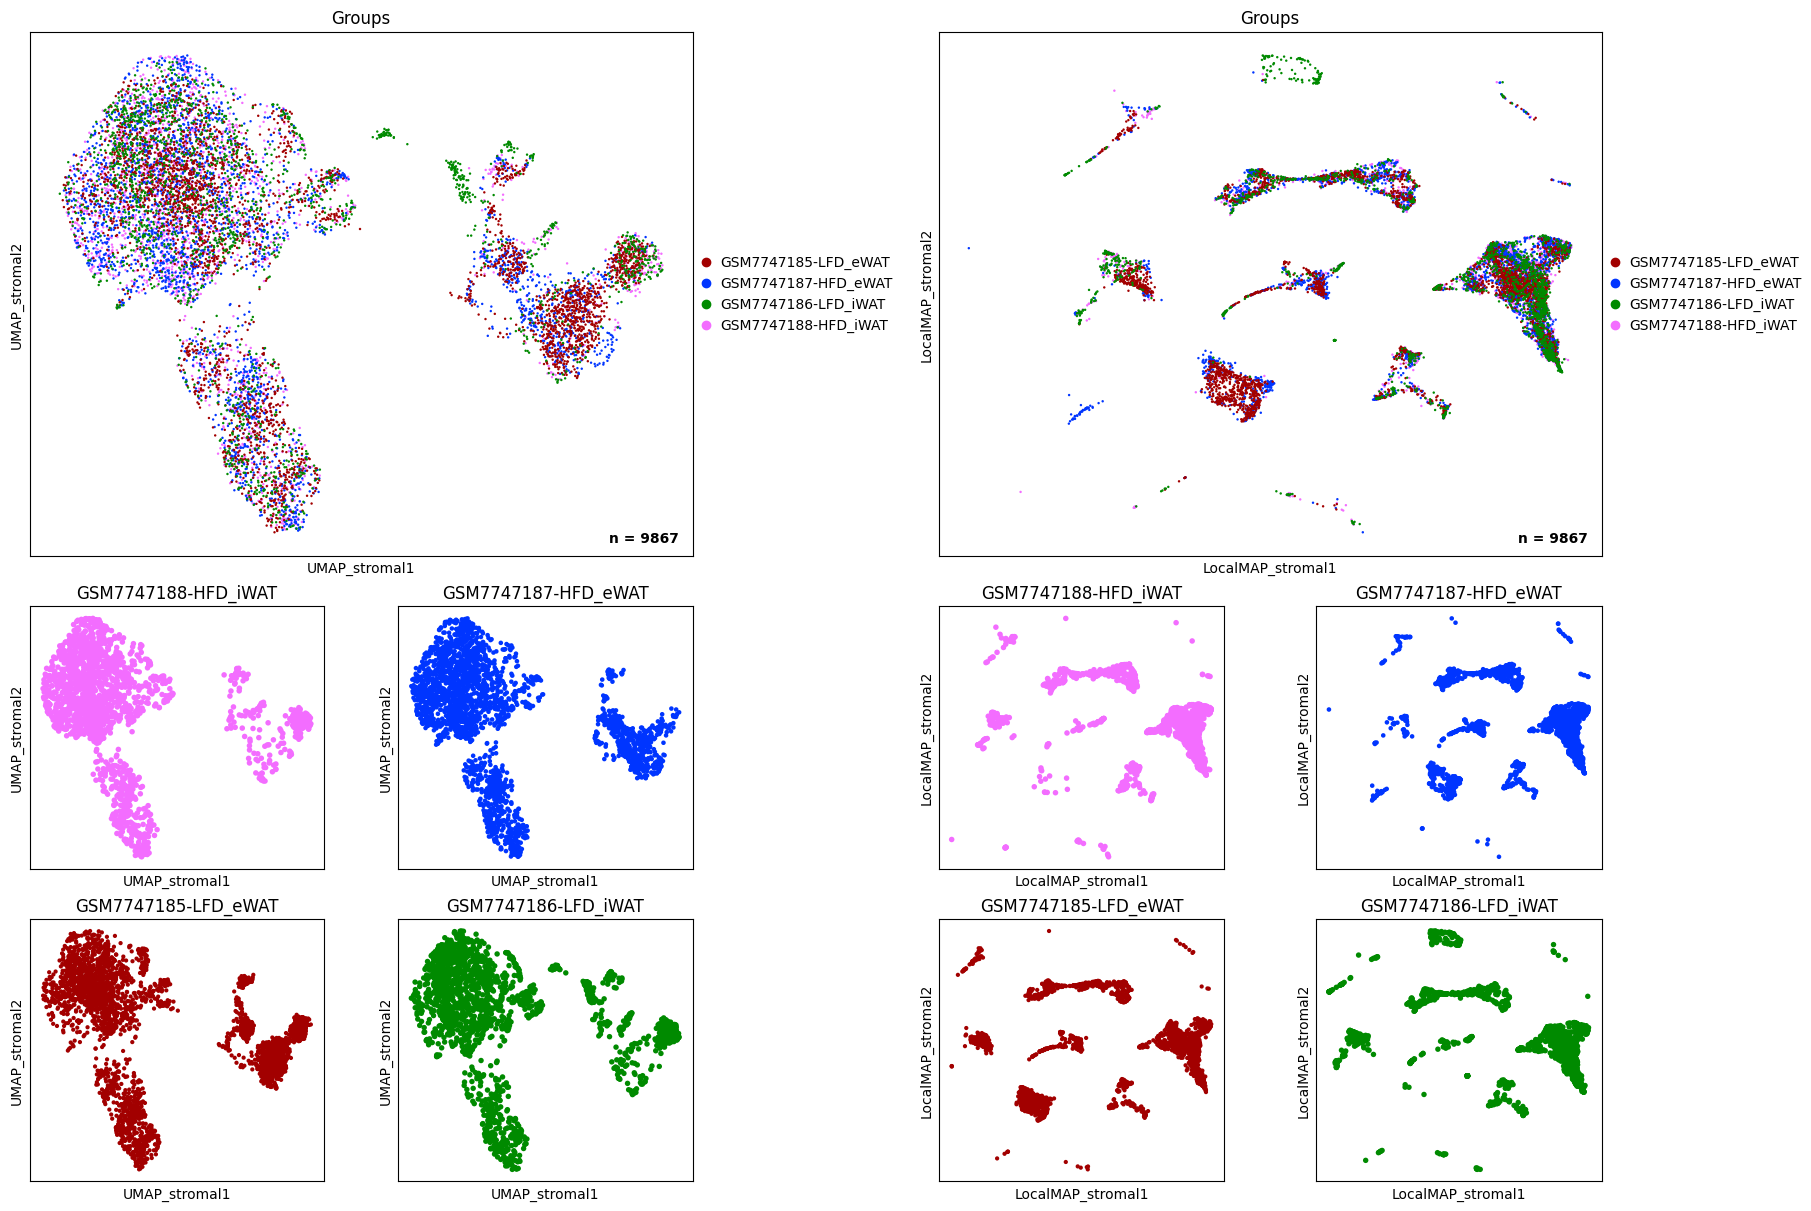

In [5]:
# integration check
f = plt.figure(figsize=(18, 12), layout="constrained")
check_integration(
    adata_stromal,
    "Groups",
    f,
    embeddings=["UMAP_stromal", "LocalMAP_stromal"],
    nrow=2,
    ncol=2,
)

### Clusters

<Axes: title={'center': 'Sample Type'}, xlabel='LocalMAP_stromal1', ylabel='LocalMAP_stromal2'>

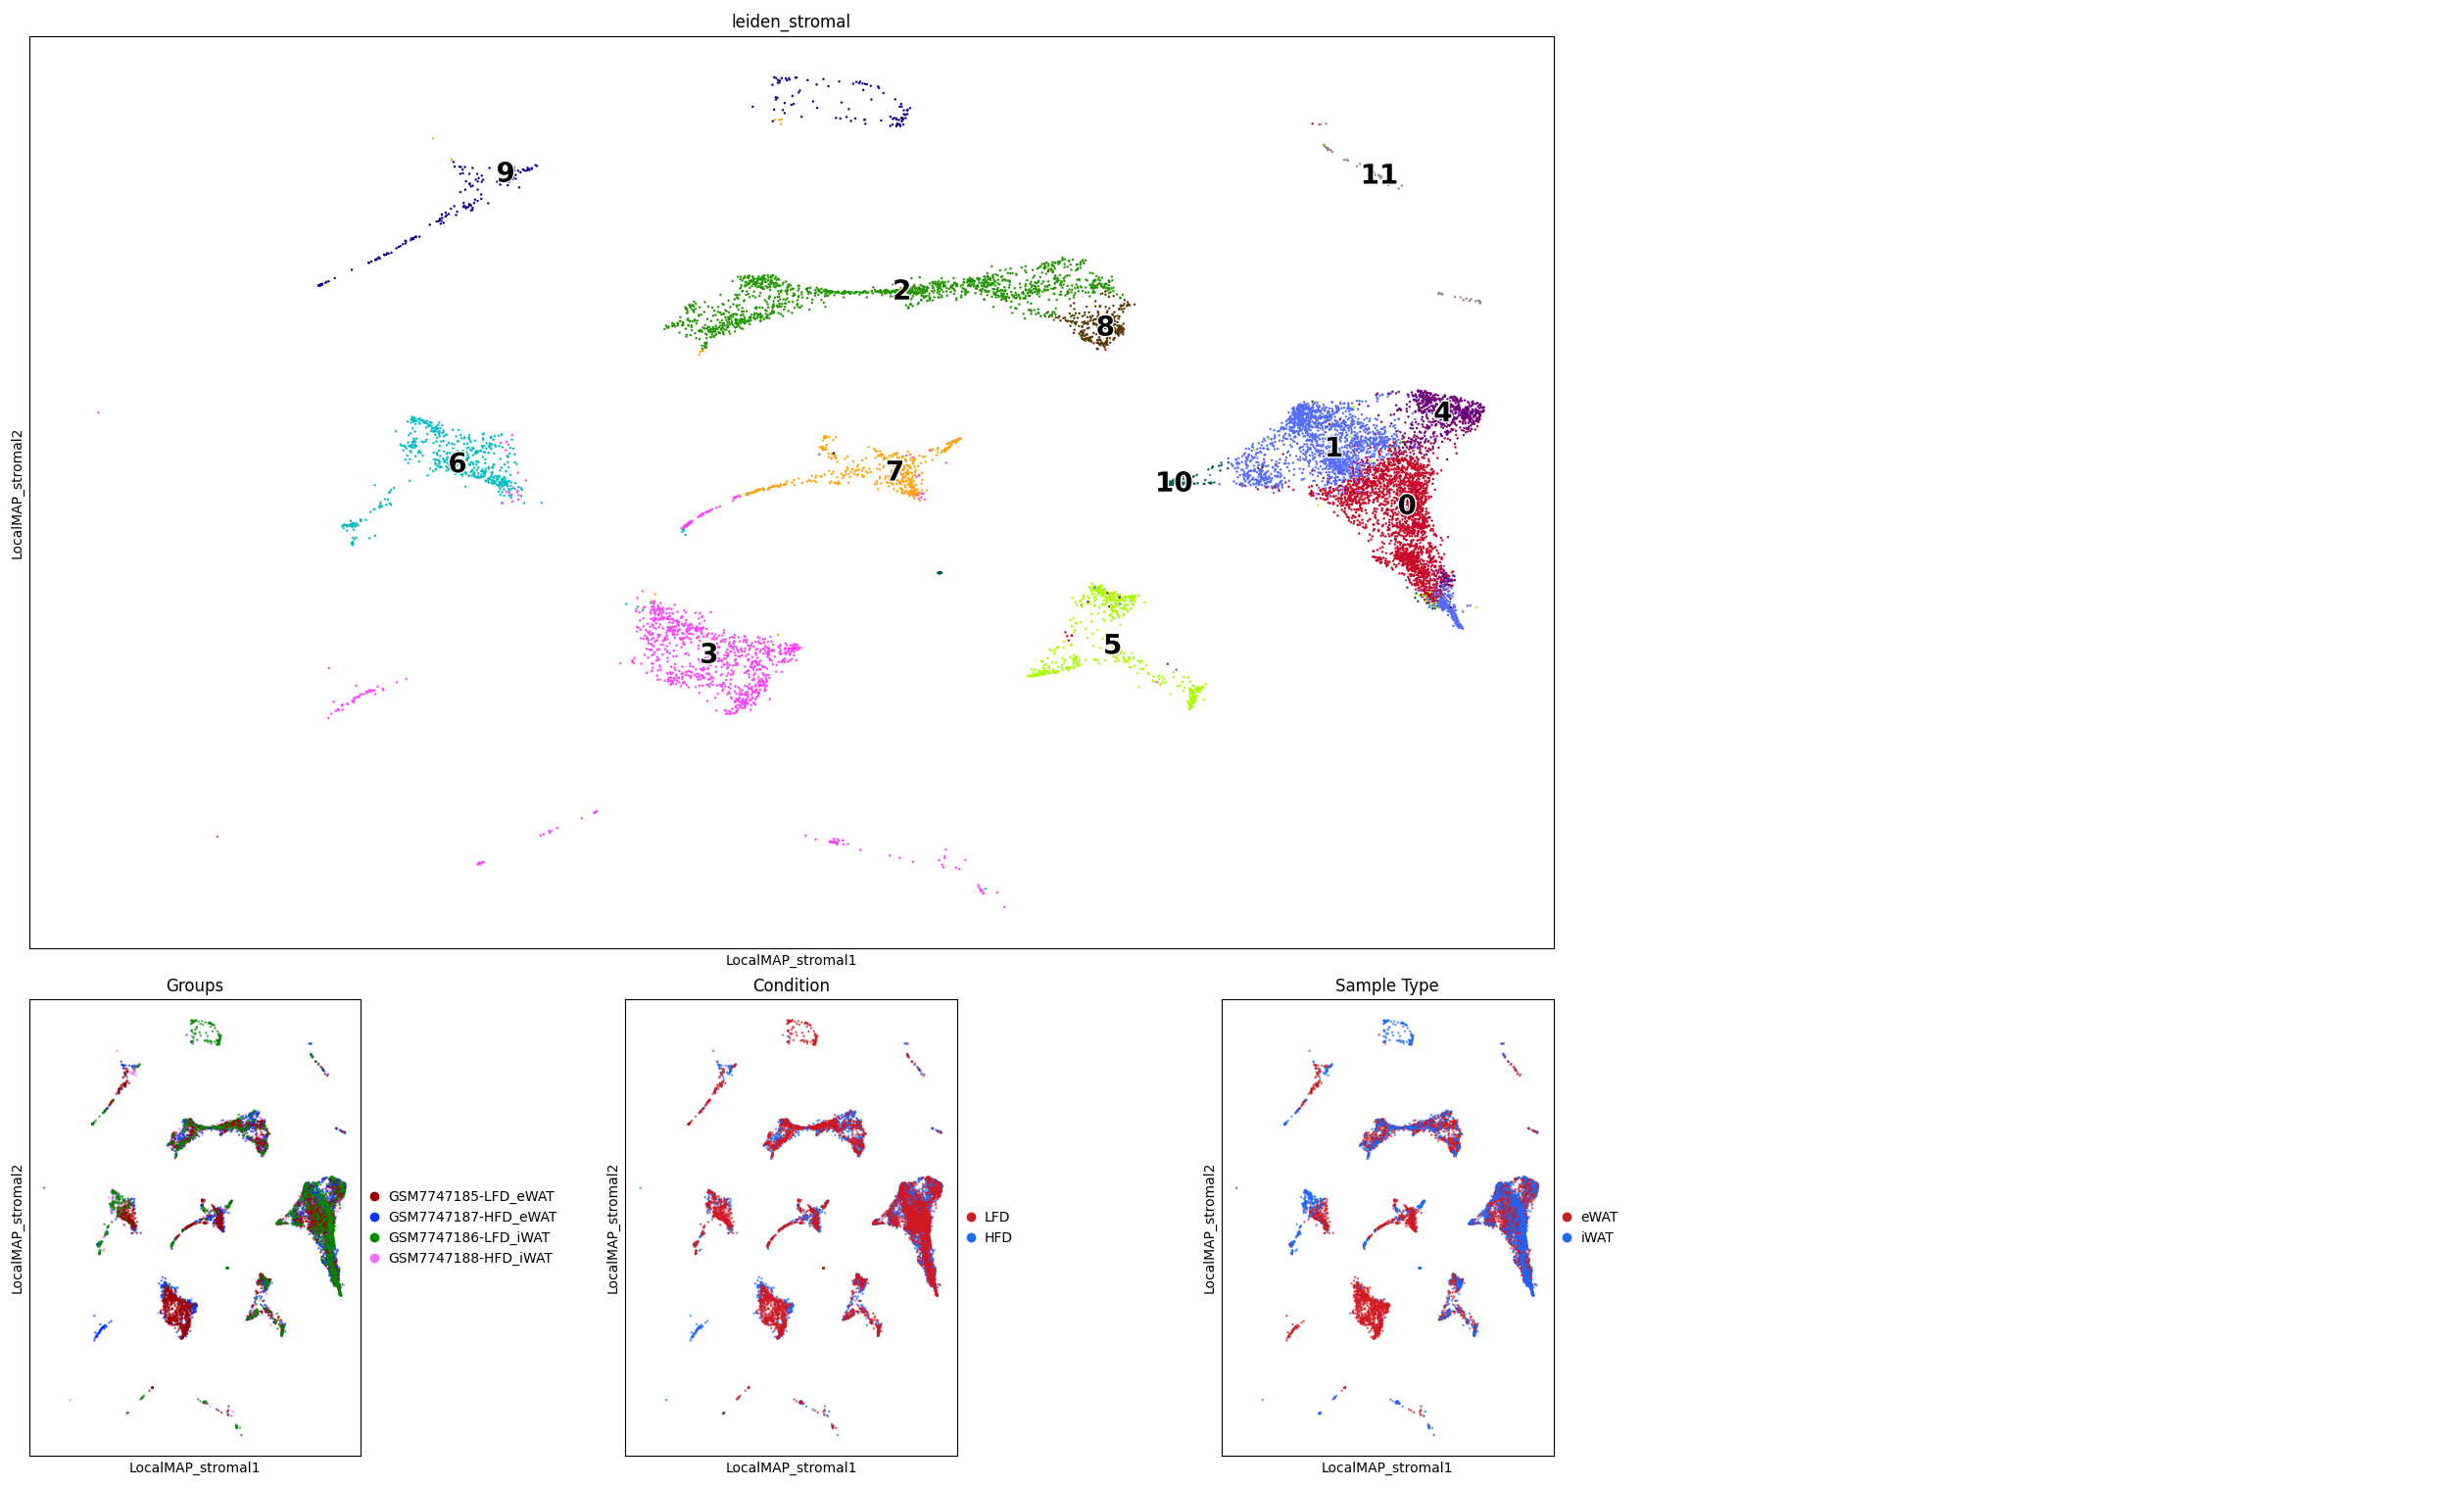

In [ ]:
recluster = False
key = "leiden_stromal"

if recluster is True:
    sc.tl.leiden(adata_stromal, resolution=0.5, key_added=key)
    # order_obs(adata_fibros,"leiden_fibro",pd.Series([2,1,6,0,4,3,7,5]).astype(str))

# figure prep
cluster_c = color_gen(adata_stromal.obs[key]).to_list()
f = plt.figure(figsize=(25, 15), layout="constrained")
sf = f.subfigures(1, 2, width_ratios=[2, 1])

axs = sf[0].subplots(3, 3)
gs = axs[0, 0].get_gridspec()
empty_axs(axs)

# Large LocalMAP plot
embedding = "LocalMAP_stromal"  # "UMAP_stromal" # "LocalMAP_stromal"
ax = sf[0].add_subplot(gs[:2, :])
sc.pl.embedding(
    adata_stromal,
    basis=embedding,
    color=[key],
    ax=ax,
    show=False,
    legend_loc="on data",
    legend_fontoutline=2,
    legend_fontsize=20,
    palette=cluster_c,
)
ax = sf[0].add_subplot(gs[2, 0])
sc.pl.embedding(
    adata_stromal,
    basis=embedding,
    color=["Groups"],
    ax=ax,
    show=False,
    alpha=0.7,
    palette=color_gen(adata_stromal.obs["Groups"]).to_list(),
)
ax = sf[0].add_subplot(gs[2, 1])
sc.pl.embedding(
    adata_stromal,
    basis=embedding,
    color=["Condition"],
    ax=ax,
    show=False,
    alpha=0.7,
    palette=color_gen(adata_stromal.obs["Condition"]).to_list(),
)
ax = sf[0].add_subplot(gs[2, 2])
sc.pl.embedding(
    adata_stromal,
    basis=embedding,
    color=["Sample Type"],
    ax=ax,
    show=False,
    alpha=0.7,
    palette=color_gen(adata_stromal.obs["Sample Type"]).to_list(),
)

# Violin marker plots
markers = [
    "Upk3b",
    "Cdh5",
    "Rgs5",
    "Selp",
    "Gja5",
    "Car4",
    "Sema3g",
    "Pgf",
    "Scd1",
    "Kcnq5",
    "Dgkb",
    "Mmrn1",
]
plot_violinplot(adata_stromal, markers, key, sf[1])

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


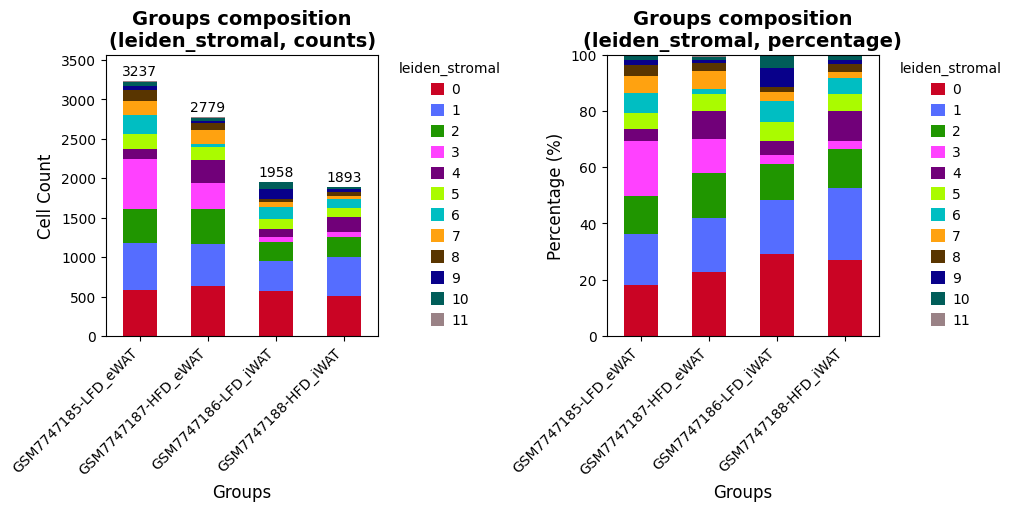

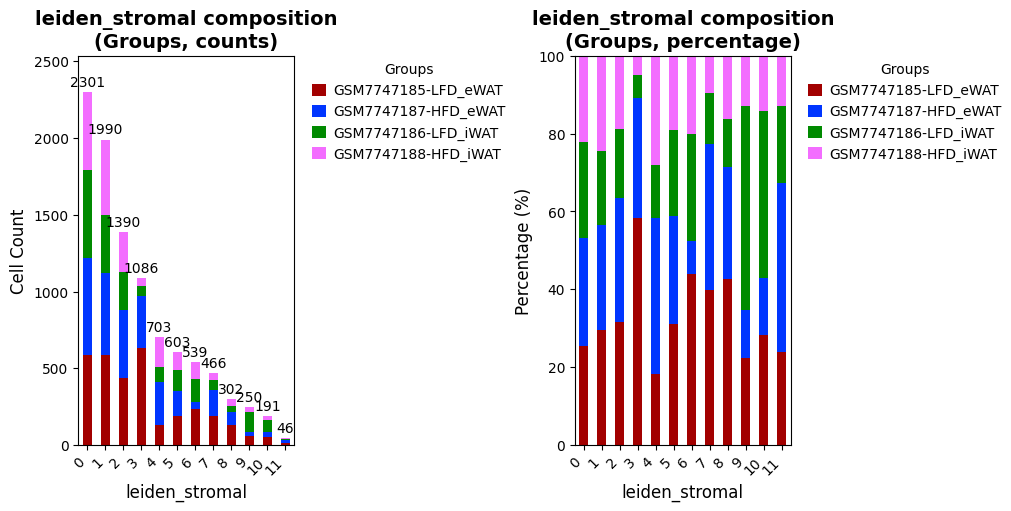

In [7]:
# cluster composition
cluster_key = "leiden_stromal"
group_key = "Groups"

f = plt.figure(figsize=(10, 5), layout="constrained")
axs = f.subplots(1, 2)
plot_cluster_stackedbarplot(adata_stromal, group_key, cluster_key, pct=False, ax=axs[0])
plot_cluster_stackedbarplot(adata_stromal, group_key, cluster_key, pct=True, ax=axs[1])

f = plt.figure(figsize=(10, 5), layout="constrained")
axs = f.subplots(1, 2)
plot_cluster_stackedbarplot(adata_stromal, cluster_key, group_key, pct=False, ax=axs[0])
plot_cluster_stackedbarplot(adata_stromal, cluster_key, group_key, pct=True, ax=axs[1])

pd.crosstab(adata_stromal.obs[cluster_key], adata_stromal.obs[group_key])

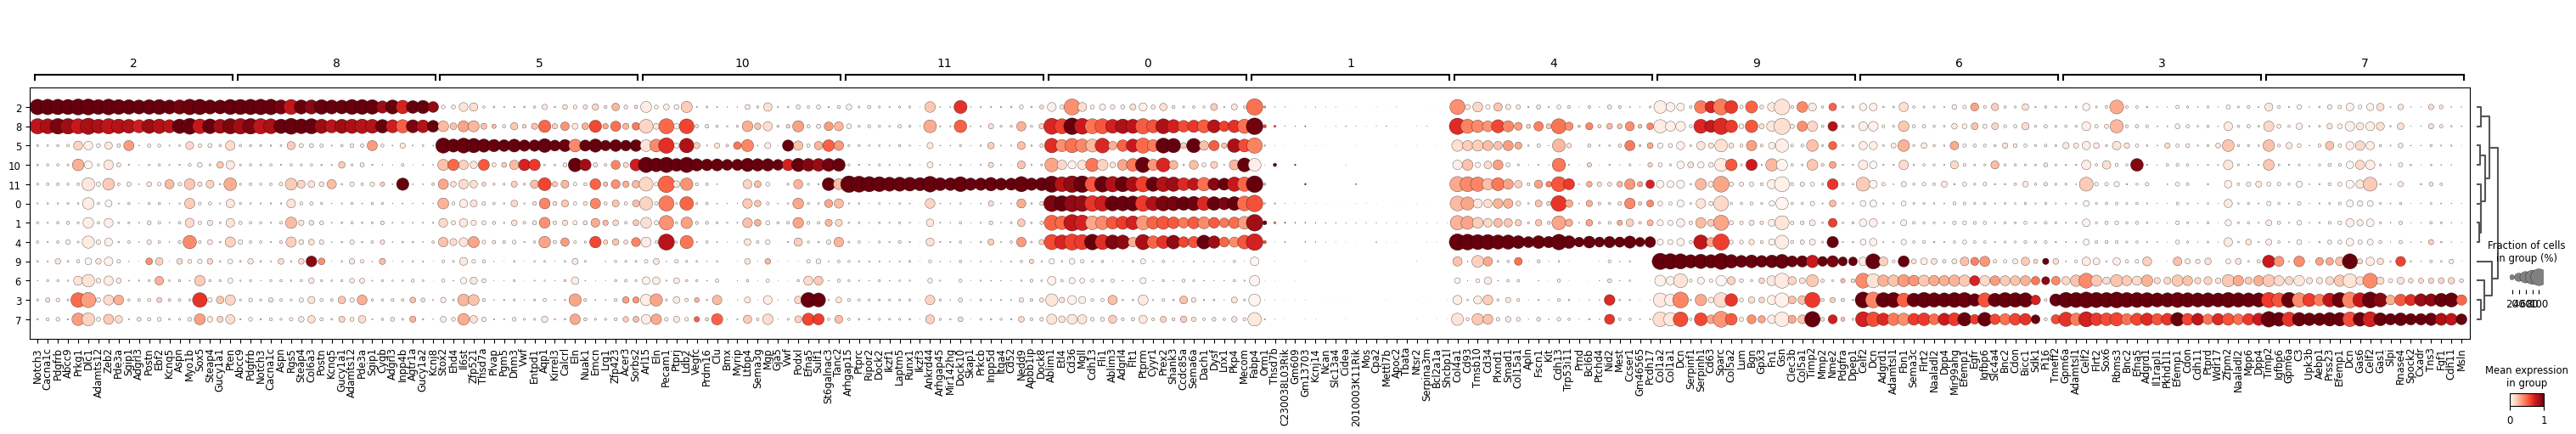

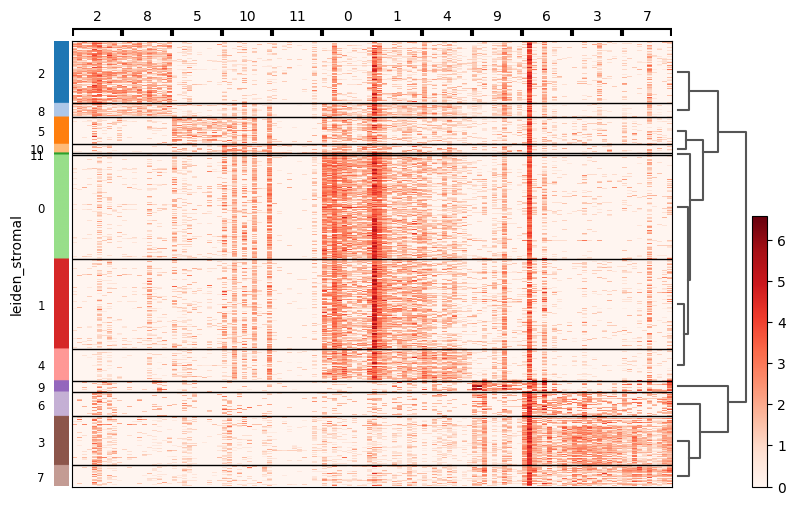

In [8]:
# original subclusters
de_key = "de_stromal_sub"
cluster_key = "leiden_stromal"

clear_uns(adata_stromal, cluster_key)
sc.tl.rank_genes_groups(
    adata_stromal,
    groupby=cluster_key,
    key_added=de_key,
    use_raw=False,
    layer="normalized",
    method="wilcoxon",
)
f, ax = plt.subplots(1, 1, figsize=(30, 5), layout="constrained")
sc.pl.rank_genes_groups_dotplot(
    adata_stromal,
    groupby=cluster_key,
    key=de_key,
    standard_scale="var",
    n_genes=20,
    min_logfoldchange=2,
    ax=ax,
)
sc.pl.rank_genes_groups_heatmap(
    adata_stromal, key=de_key, groupby=[cluster_key], layer="normalized"
)

# Cluster Regrouping

In [ ]:
old_cluster_key = "leiden_stromal"
cluster_key = f"{old_cluster_key}_group"
group_key = "Groups"

adata_stromal.obs[cluster_key] = (
    adata_stromal.obs[old_cluster_key]
    .map(
        {
            # "1": 1,
            # "2": 1,
            # "0": 2,
            # "3": 2,
            # "4": 3,
            # "5": 4,
        }
    )
    .astype(str)
)

# reannotate
order_obs(
    adata_stromal,
    cluster_key,
    pd.Series(np.sort(adata_stromal.obs[cluster_key].unique())).astype(str),
)

f = plt.figure(figsize=(10, 5), layout="constrained")
axs = f.subplots(1, 2)
plot_cluster_stackedbarplot(adata_stromal, group_key, cluster_key, pct=False, ax=axs[0])
plot_cluster_stackedbarplot(adata_stromal, group_key, cluster_key, pct=True, ax=axs[1])

f = plt.figure(figsize=(10, 5), layout="constrained")
axs = f.subplots(1, 2)
plot_cluster_stackedbarplot(adata_stromal, cluster_key, group_key, pct=False, ax=axs[0])
plot_cluster_stackedbarplot(adata_stromal, cluster_key, group_key, pct=True, ax=axs[1])

pd.crosstab(adata_stromal.obs[cluster_key], adata_stromal.obs[group_key])

In [ ]:
group_key = "leiden_stromal_group"
de_key = "de_stromal"

# grouped vs original subclusters
clear_uns(adata_stromal, group_key)

# run DEGs
sc.tl.rank_genes_groups(
    adata_stromal,
    groupby=group_key,
    key_added=de_key,
    use_raw=False,
    layer="normalized",
    method="wilcoxon",
)

# plot DEGs dotplot
f, ax = plt.subplots(1, 1, figsize=(30, 5), layout="constrained")
sc.pl.rank_genes_groups_dotplot(
    adata_stromal,
    groupby=group_key,
    key=de_key,
    standard_scale="var",
    n_genes=20,
    min_logfoldchange=2,
    ax=ax,
)

# plot DEGs heatmap
sc.pl.rank_genes_groups_heatmap(
    adata_stromal, key=de_key, groupby=group_key, layer="normalized", n_genes=50
)

In [ ]:
# figure prep
key = "leiden_stromal_group"
embedding = "LocalMAP_stromal"  # "UMAP_stromal"

# figure prep
cluster_c = color_gen(adata_stromal.obs[key])
f = plt.figure(figsize=(25, 15), layout="constrained")
sf = f.subfigures(1, 2, width_ratios=[2, 1])

axs = sf[0].subplots(3, 3)
gs = axs[0, 0].get_gridspec()
empty_axs(axs)

# Large LocalMAP plot
ax = sf[0].add_subplot(gs[:2, :])
sc.pl.embedding(
    adata_stromal,
    basis=embedding,
    color=[key],
    ax=ax,
    show=False,
    legend_loc="on data",
    legend_fontoutline=2,
    legend_fontsize=20,
    palette=cluster_c.to_list(),
)
ax = sf[0].add_subplot(gs[2, 0])
sc.pl.embedding(
    adata_stromal,
    basis=embedding,
    color=["Groups"],
    ax=ax,
    show=False,
    alpha=0.7,
    palette=color_gen(adata_stromal.obs["Groups"]).to_list(),
)
ax = sf[0].add_subplot(gs[2, 1])
sc.pl.embedding(
    adata_stromal,
    basis=embedding,
    color=["Condition"],
    ax=ax,
    show=False,
    alpha=0.7,
    palette=color_gen(adata_stromal.obs["Condition"]).to_list(),
)
ax = sf[0].add_subplot(gs[2, 2])
sc.pl.embedding(
    adata_stromal,
    basis=embedding,
    color=["Sample Type"],
    ax=ax,
    show=False,
    alpha=0.7,
    palette=color_gen(adata_stromal.obs["Sample Type"]).to_list(),
)

# Violin marker plots
markers = ["Adipoq", "Fam13a", "Fgf14", "Mageb18", "Cacna1e", "Cfd", "B2m"]
plot_violinplot(adata_stromal, markers, key, sf[1])

In [ ]:
# relevant subsets
ewat_stromal = adata_stromal[adata_stromal.obs["Sample Type"] == "eWAT"].copy()
lfd_ewat_stromal = ewat_stromal[ewat_stromal.obs["Condition"] == "LFD"].copy()
hfd_ewat_stromal = ewat_stromal[ewat_stromal.obs["Condition"] == "HFD"].copy()

# Dissecting clusters

In [ ]:
# define markers

tgfb_genes = [
    "Il33",
    "Ly6a",
    "Ccl2",
    "Dpp4",  # No response
    "Smad2",
    "Smad3",
    "Smad4",
    "Serpine1",
    "Id1",
    "Id2",
    "Id3",  # Intermediate responsive
    "Fn1",
    "Postn",
    "Cthrc1",
    "Vim",
    "Col1a1",
    "Col1a2",
    "Serpinh1",  # High responsive
]

ifn_genes = [
    "Fasn",
    "Irs1",
    "Insr",  # Repressed
    "Irf3",
    "Irf4",
    "Ifi47",
    "Irf1",
    "Ifitm1",
    "Ifitm2",
    "Ifitm3",  # Induced
]

cytokine_markers = pd.Series(tgfb_genes + ifn_genes).unique().tolist()

In [ ]:
# All FBs
pop_name = "All FBs"

f = plt.figure(figsize=(20, 20), layout="constrained")
plot_cluster_violinplot(
    adata_fibros, "Condition", "leiden_fibro_group", selected_markers, f
)
f.suptitle(
    f"HFD vs LFD expression by cluster ({pop_name})\nSelected markers", fontsize=30
)

f = plt.figure(figsize=(20, 20), layout="constrained")
plot_cluster_violinplot(adata_fibros, "Condition", "leiden_fibro_group", tgfb_genes, f)
f.suptitle(
    f"HFD vs LFD expression by cluster {pop_name})\nCurated TGFβ-responsive genes",
    fontsize=30,
)

f = plt.figure(figsize=(20, 20), layout="constrained")
plot_cluster_violinplot(adata_fibros, "Condition", "leiden_fibro_group", ifn_genes, f)
f.suptitle(
    f"HFD vs LFD expression by cluster ({pop_name})\nCurated IFN-responsive genes",
    fontsize=30,
)

In [ ]:
# eWAT FBs
pop_name = "eWAT FBs"
ewat_fibros = adata_fibros[adata_fibros.obs["Sample Type"] == "eWAT"].copy()
ewat_fibros = ewat_fibros[ewat_fibros.obs["leiden_fibro_group"] != "4"].copy()

f = plt.figure(figsize=(20, 20), layout="constrained")
plot_cluster_violinplot(
    ewat_fibros, "Condition", "leiden_fibro_group", selected_markers, f
)
f.suptitle(
    f"HFD vs LFD expression by cluster ({pop_name})\nSelected markers", fontsize=30
)

f = plt.figure(figsize=(20, 20), layout="constrained")
plot_cluster_violinplot(ewat_fibros, "Condition", "leiden_fibro_group", tgfb_genes, f)
f.suptitle(
    f"HFD vs LFD expression by cluster ({pop_name})\nCurated TGFβ-responsive genes",
    fontsize=30,
)

f = plt.figure(figsize=(20, 20), layout="constrained")
plot_cluster_violinplot(ewat_fibros, "Condition", "leiden_fibro_group", ifn_genes, f)
f.suptitle(
    f"HFD vs LFD expression by cluster ({pop_name})\nCurated IFN-responsive genes",
    fontsize=30,
)

axs = sc.pl.embedding(
    ewat_fibros,
    basis="LocalMAP_fibro",
    layer="normalized",
    color=all_fibro_markers + ["leiden_fibro", "leiden_fibro_group", "Condition"],
    ncols=5,
    alpha=0.7,
    show=False,
    color_map=DEFAULT_CMAP,
)
f = axs[0].get_figure()
f.suptitle("Feature plots for all markers (All FBs)", fontsize=30)

# ewat_fibros.obs["Condition-Cluster"] = (ewat_fibros.obs["Condition"].astype(str) + "-Cluster_" + ewat_fibros.obs["leiden_fibro_group"].astype(str)).astype("category")
# order_obs(ewat_fibros, "Condition-Cluster",['LFD-Cluster_1', 'LFD-Cluster_2', 'LFD-Cluster_3',
#                                             'HFD-Cluster_1', 'HFD-Cluster_2', 'HFD-Cluster_3'])

# f = plt.figure(figsize=(10,15),layout="constrained")
# plot_violinplot(ewat_fibros, tgfb_genes, "Condition-Cluster", f, bracket_params={"ratio" : [1,1],
#                                                                                    "labels" : ["LFD", "HFD"],
#                                                                                    "bracket_y" : 0.4,
#                                                                                    "label_y" : 0.65,
#                                                                                    "padding" : 35})
# f.suptitle("HFD vs LFD expression by cluster (TGFβ-response genes)", fontsize=15)

In [ ]:
f = plt.figure(figsize=(15, 5), layout="constrained")
axs = f.subplots(1, 3)
sc.pl.embedding(
    ewat_fibros,
    basis="LocalMAP_fibro",
    layer="normalized",
    color=["leiden_fibro"],
    alpha=0.7,
    legend_loc="on data",
    ax=axs[0],
    show=False,
    palette=color_gen(ewat_fibros.obs["leiden_fibro"]).to_list(),
)
sc.pl.embedding(
    ewat_fibros,
    basis="LocalMAP_fibro",
    layer="normalized",
    color=["leiden_fibro_group"],
    alpha=0.7,
    legend_loc="on data",
    ax=axs[1],
    show=False,
    palette=color_gen(ewat_fibros.obs["leiden_fibro_group"]).to_list(),
)
sc.pl.embedding(
    ewat_fibros,
    basis="LocalMAP_fibro",
    layer="normalized",
    color=["Condition"],
    alpha=0.7,
    ax=axs[2],
    show=False,
)

In [ ]:
# specified features plots
features_plot = [
    "Ifitm3",
    "Ly6a",
    "Id2",
    "Id3",
    "Fn1",
    "Postn",
    "Serpinh1",
    "Cd44",
    "Dpp4",
    "Itga6",
    "Cd55",
    "Tgfb1",
    "Tgfb2",
    "Tgfb3",
    "Tgfbr1",
    "Tgfbr2",
    "Il1rn",
    "Il13ra1",
    "Il17ra",
    "Il33",
    "Ifng",
    "Ifngr1",
    "Ifnar1",
    "Ifnar2",
    "Pparg",
    "Ccl2",
    "Ccl7",
    "Cxcl16",
    "Cxcl12",
    "Pi16",
    "Saa3",
    "Col14a1",
]

# all eWAT
ax = sc.pl.embedding(
    ewat_fibros,
    basis="LocalMAP_fibro",
    layer="normalized",
    color=features_plot,
    ncols=5,
    alpha=0.7,
    color_map=DEFAULT_CMAP,
    return_fig=True,
    show=False,
)
f = ax.get_figure()
f.suptitle(f"Pan-Condition eWAT expression of Selected markers", fontsize=30)

# LFD
ax = sc.pl.embedding(
    lfd_ewat_fibros,
    basis="LocalMAP_fibro",
    layer="normalized",
    color=features_plot,
    ncols=5,
    alpha=0.7,
    color_map=DEFAULT_CMAP,
    return_fig=True,
    show=False,
)
f = ax.get_figure()
f.suptitle(f"LFD expression of Selected markers", fontsize=30)

# HFD
ax = sc.pl.embedding(
    hfd_ewat_fibros,
    basis="LocalMAP_fibro",
    layer="normalized",
    color=features_plot,
    ncols=5,
    alpha=0.7,
    color_map=DEFAULT_CMAP,
    return_fig=True,
    show=False,
)
f = ax.get_figure()
f.suptitle(f"HFD expression of Selected markers", fontsize=30)

In [ ]:
# original subclusters
clear_uns(ewat_fibros, "leiden_fibro_group")
sc.tl.rank_genes_groups(
    ewat_fibros,
    groupby="leiden_fibro_group",
    key_added="de_fibro_ewat_clusters",
    use_raw=False,
    layer="normalized",
    method="wilcoxon",
)
f, ax = plt.subplots(1, 1, figsize=(30, 5), layout="constrained")
sc.pl.rank_genes_groups_dotplot(
    ewat_fibros,
    groupby="leiden_fibro_group",
    key="de_fibro_ewat_clusters",
    standard_scale="var",
    n_genes=40,
    min_logfoldchange=2,
    ax=ax,
)

### ORA Enrichment

In [ ]:
sources = ["GO:MF", "GO:CC", "KEGG", "REAC"]

GOterms = GO_Enrich(
    adata_fibros,
    "leiden_fibro_group",
    "de_fibro",
    sources=sources,
    pval_cutoff=1e-5,
    log2fc_min=1,
)

figsizes = [(8, 12), (8, 14), (8, 8), (8, 10)]
for n, source in enumerate(sources):
    fig = plot_go_enrichment(
        df_dict=GOterms[source],
        pvalue_col="p_value",
        score_col="term_size",
        pvalue_threshold=0.05,
        rank_by="pvalue",
        top_n=15,
        use_log_pvalue=True,
        use_log_score=False,
        figsize=figsizes[n],
        database=source,
    )

    plt.show()

### GSEA

In [ ]:
ref_dir = os.path.join(REFDIR, "interactome")
hallmark = dc.pp.read_gmt(os.path.join(ref_dir, "mh.all.v2025.1.Mm.symbols.gmt"))

tgfb_genes = hallmark[hallmark.source.isin(["HALLMARK_TGF_BETA_SIGNALING"])].target
tnfa_genes = hallmark[hallmark.source.isin(["HALLMARK_TNFA_SIGNALING_VIA_NFKB"])].target
il_genes = hallmark[
    hallmark.source.isin(
        ["HALLMARK_IL2_STAT5_SIGNALING", "HALLMARK_IL6_JAK_STAT3_SIGNALING"]
    )
].target
ifn_genes = hallmark[
    hallmark.source.isin(
        ["HALLMARK_INTERFERON_ALPHA_RESPONSE", "HALLMARK_INTERFERON_GAMMA_RESPONSE"]
    )
].target
collections = [
    "HALLMARK_TGF_BETA_SIGNALING",
    "HALLMARK_TNFA_SIGNALING_VIA_NFKB",
    "HALLMARK_IL2_STAT5_SIGNALING",
    "HALLMARK_IL6_JAK_STAT3_SIGNALING",
    "HALLMARK_INTERFERON_ALPHA_RESPONSE",
    "HALLMARK_INTERFERON_GAMMA_RESPONSE",
]

In [ ]:
# GSEApy approach, by cluster
pd.Series(gp.get_library_name())

custom_gsea = [
    os.path.join(ref_dir, "mh.all.v2025.1.Mm.symbols.gmt"),
    os.path.join(ref_dir, "m2.cp.v2025.1.Mm.symbols.gmt"),
    os.path.join(ref_dir, "m3.all.v2025.1.Mm.symbols.gmt"),
    os.path.join(ref_dir, "m5.go.v2025.1.Mm.symbols.gmt"),
    # os.path.join(ref_dir,"m7.all.v2025.1.Mm.symbols.gmt"),
    # os.path.join(ref_dir,"m8.all.v2025.1.Mm.symbols.gmt"),
]
provided_gsea = []
total_gsea = custom_gsea + provided_gsea

preranks = []
cond_gsea_results = {}

for group in ewat_fibros.obs["leiden_fibro_group"].unique():
    df = sc.get.rank_genes_groups_df(ewat_fibros, group=group, key="de_fibro")
    ranking = df[["names", "scores"]]
    prerank = gp.prerank(
        rnk=ranking, gene_sets=total_gsea, seed=6, threads=7, permutation_num=100
    )

    result = prerank.res2d
    names = result["Term"].str.split("__", expand=True)
    result["Collection"] = names[0]
    result["Term"] = names[1]
    cond_gsea_results[group] = result

    # gsea = gp.gsea(rnk = ranking,
    #                     gene_sets = total_gsea,
    #                     seed = 6, permutation_num = 100)

    # ssgsea = gp.ssgsea(rnk = ranking,
    #                     gene_sets = total_gsea,
    #                     seed = 6, permutation_num = 100)

annotation = "manDoublet-seuratV3-harmony-leiden_1-fibro_leiden_0.5 - GSEA by cluster"
savedir = os.path.join(DATADIR, "processed", study, "py", "4_subclustered")
os.makedirs(savedir, exist_ok=True)
with open(os.path.join(savedir, f"{annotation}.pickle"), "wb") as handle:
    pickle.dump(cond_gsea_results, handle)

f, ax = plt.subplots(1, 3, figsize=(50, 15), layout="constrained")
collection_cols = color_gen(pd.Series(total_gsea))
for n, cluster in enumerate(cond_gsea_results):
    gp.plot.barplot(
        cond_gsea_results[cluster],
        "ES",
        group="Collection",
        top_term=10,
        ax=ax[n],
        color=collection_cols,
    )
    ax[n].set_title(f"Cluster {cluster}", size=30)
    if n != len(ax) - 1:
        ax[n].legend_ = None
f.suptitle("GSEAs by Cluster (1 vs rest)", size=45)

In [ ]:
# GSEApy approach, by HFD/LFD per cluster

custom_gsea = [
    os.path.join(ref_dir, "mh.all.v2025.1.Mm.symbols.gmt"),
    os.path.join(ref_dir, "m2.cp.v2025.1.Mm.symbols.gmt"),
    # os.path.join(ref_dir,"m3.all.v2025.1.Mm.symbols.gmt"),
    os.path.join(ref_dir, "m5.go.v2025.1.Mm.symbols.gmt"),
    os.path.join(ref_dir, "m7.all.v2025.1.Mm.symbols.gmt"),
    os.path.join(ref_dir, "m8.all.v2025.1.Mm.symbols.gmt"),
]
provided_gsea = []
total_gsea = custom_gsea + provided_gsea

preranks = []
clust_cond_gsea_results = {}

for cluster in ewat_fibros.obs["leiden_fibro_group"].unique():
    # define subset
    cluster_ewat_fibros = ewat_fibros[ewat_fibros.obs["leiden_fibro_group"] == cluster]

    # run DEGs
    sc.tl.rank_genes_groups(
        cluster_ewat_fibros,
        groupby="Condition",
        key_added=f"de_cluster{cluster}_condition",
        use_raw=False,
        layer="normalized",
        method="wilcoxon",
    )

    clust_cond_gsea_results[cluster] = {}
    for condition in cluster_ewat_fibros.obs["Condition"].unique():
        # access DEGs
        df = sc.get.rank_genes_groups_df(
            cluster_ewat_fibros, group=condition, key=f"de_cluster{cluster}_condition"
        )
        ranking = df[["names", "scores"]]

        # run GSEA
        prerank = gp.prerank(
            rnk=ranking, gene_sets=total_gsea, seed=6, threads=7, permutation_num=100
        )

        # save result for plotting
        result = prerank.res2d
        names = result["Term"].str.split("__", expand=True)
        result["Collection"] = names[0]
        result["Term"] = names[1]
        clust_cond_gsea_results[cluster][condition] = result

annotation = (
    "manDoublet-seuratV3-harmony-leiden_1-fibro_leiden_0.5 - GSEA condition by cluster"
)
savedir = os.path.join(DATADIR, "processed", study, "py", "4_subclustered")
os.makedirs(savedir, exist_ok=True)
with open(os.path.join(savedir, f"{annotation}.pickle"), "wb") as handle:
    pickle.dump(clust_cond_gsea_results, handle)

# plot
collection_cols = color_gen(pd.Series(total_gsea))
for n, cluster in enumerate(clust_cond_gsea_results):
    f, ax = plt.subplots(1, 2, figsize=(40, 20), layout="constrained")
    for m, condition in enumerate(clust_cond_gsea_results[cluster]):
        gp.plot.barplot(
            clust_cond_gsea_results[cluster][condition],
            "ES",
            group="Collection",
            top_term=10,
            ax=ax[m],
            color=collection_cols,
        )
        ax[m].set_title(f"{condition}", size=20)
        if m != len(ax) - 1:
            ax[m].legend_ = None
    f.suptitle(f"GSEAs by Condition, Cluster {cluster}", size=30)

In [ ]:
cluster = "1"
condition = "HFD"
gs_res = clust_cond_gsea_results[str(cluster)][condition]

for coll in collections:
    tmp = gs_res[gs_res["Term"].isin([coll])]
    lead_genes = tmp["Lead_genes"].str.split(";", expand=True)
    lead_genes = pd.Series(lead_genes.to_numpy().flatten()).dropna().unique()
    f = sc.pl.embedding(
        ewat_fibros, basis="LocalMAP_fibro", color=lead_genes, ncols=8, return_fig=True
    )
    f.suptitle(
        f"{coll} Lead Genes ($ES={float(tmp["NES"]):.2f}, FDR={float(tmp["FDR q-val"]):.2f}$)",
        size=40,
    )

In [ ]:
# Decoupler method
run_GSEA = True

# get geneset info
gsea_sets = {
    "FIBRO_MSigDB-MH": os.path.join(ref_dir, "mh.all.v2025.1.Mm.symbols.gmt"),
    "FIBRO_MSigDB-M2-CP": os.path.join(ref_dir, "m2.cp.v2025.1.Mm.symbols.gmt"),
    # "FIBRO_MSigDB-M3" : os.path.join(ref_dir,"m3.all.v2025.1.Mm.symbols.gmt"),
    "FIBRO_MSigDB-M5-GO": os.path.join(ref_dir, "m5.go.v2025.1.Mm.symbols.gmt"),
    "FIBRO_MSigDB-M7": os.path.join(ref_dir, "m7.all.v2025.1.Mm.symbols.gmt"),
    # "FIBRO_MSigDB-M8" : os.path.join(ref_dir,"m8.all.v2025.1.Mm.symbols.gmt"),
    "FIBRO_CollecTRI": dc.op.collectri(organism="mouse"),
}

# run GSEA
if run_GSEA is True:
    for name, geneset in gsea_sets.items():
        if type(geneset) is str:
            GSEA_decoupler(
                ewat_fibros, name, type="ULM", geneset_dir=geneset, remove_prefix=False
            )
        else:
            GSEA_decoupler(ewat_fibros, name, type="ULM", geneset=geneset)

# plot
f = plt.figure(figsize=(len(gsea_sets) * 8, 10), layout="constrained")
sf = f.subfigures(1, len(gsea_sets))
for name in gsea_sets.keys():
    clear_uns(ewat_fibros, "dendrogram")
    clear_uns(ewat_fibros, "colors")
    plot_gsea_dc(
        ewat_fibros,
        f"GSEA ({name})",
        f"{name}_score_ulm",
        "leiden_fibro_group",
        30,
        name,
    )

In [ ]:
gsea_sets_2 = {
    "FIBRO_MSigDB-MH": os.path.join(ref_dir, "mh.all.v2025.1.Mm.symbols.gmt")
}
for name, geneset in gsea_sets_2.items():
    GSEA_decoupler(
        ewat_fibros, name, type="AUCell", geneset_dir=geneset, remove_prefix=False
    )

score = dc.pp.get_obsm(adata=ewat_fibros, key="FIBRO_MSigDB-MH_score_aucell")
sc.pl.embedding(score, basis="LocalMAP_fibro", color=collections)

### Save/Load

In [ ]:
# save
annotation = "manDoublet-seuratV3-harmony-leiden_1-stromal_leiden_0.5"
savedir = os.path.join(DATADIR, "processed", study, "py", "4_subclustered")
os.makedirs(savedir, exist_ok=True)
adata_stromal.write(os.path.join(savedir, f"{annotation}.h5ad"))

In [ ]:
# load
annotation = "manDoublet-seuratV3-harmony-leiden_1-stromal_leiden_0.5"
savedir = os.path.join(DATADIR, "processed", study, "py", "4_subclustered")
adata_stromal = sc.read_h5ad(os.path.join(savedir, f"{annotation}.h5ad"))

# relevant subsets
ewat_stromal = adata_stromal[adata_stromal.obs["Sample Type"] == "eWAT"].copy()
lfd_ewat_stromal = ewat_stromal[ewat_stromal.obs["Condition"] == "LFD"].copy()
hfd_ewat_stromal = ewat_stromal[ewat_stromal.obs["Condition"] == "HFD"].copy()

# Carlos cytokine cesponse signatures

In [ ]:
filename = os.path.join(REFDIR, "Carlos_DEseq2_data.xlsx")
exposures = pd.ExcelFile(filename).sheet_names
bulkseqs = [
    pd.read_excel(filename, sheet_name=sheet, usecols=np.arange(7), nrows=2000)
    for sheet in exposures
]
bulkseqs[0][(bulkseqs[0]["P.adj"] > 1e-5) & (bulkseqs[0]["Log2.FC."] > 1)]

In [ ]:
pval_cutoff = 1e-5
log2fc_cutoff = 1

up_signatures = dict(
    zip(
        [f"{i}_UP" for i in exposures],
        [
            data[(data["P.adj"] < pval_cutoff) & (data["Log2.FC."] > log2fc_cutoff)]
            for data in bulkseqs
        ],
    )
)
dn_signatures = dict(
    zip(
        [f"{i}_DOWN" for i in exposures],
        [
            data[(data["P.adj"] < pval_cutoff) & (data["Log2.FC."] < -log2fc_cutoff)]
            for data in bulkseqs
        ],
    )
)
signatures = up_signatures | dn_signatures

pd.DataFrame([(i[0], i[1].shape[0]) for i in signatures.items()])

In [ ]:
groups = [name for name in signatures.keys()]
ends = [0]
brackets = []
gene_names = []
for key, sig in signatures.items():
    sig_genes = sig.iloc[:, 0]
    sig_genes = sig_genes[sig_genes.isin(adata_fibros.var_names)]

    ends.append(len(sig_genes))
    gene_names.append(sig_genes)

brackets = [(np.cumsum(ends)[i], np.cumsum(ends)[i + 1]) for i in range(len(ends) - 1)]
gene_names = pd.concat(gene_names)
sc.pl.heatmap(
    adata_fibros,
    gene_names,
    groupby="leiden_fibro_group",
    var_group_positions=brackets,
    var_group_labels=groups,
    layer="normalized",
    use_raw=False,
    vmax=3,
)

adata_fibros[:, gene_names].var.nlargest(10, "means")

In [ ]:
from scipy.sparse._csr import csr_matrix

ewat_fibros.obs["Condition-Cluster"] = (
    ewat_fibros.obs["Condition"].astype(str)
    + "-Fibro_"
    + ewat_fibros.obs["leiden_fibro_group"].astype(str)
).astype("category")


def find_var_means(adata, groupby, layer="normalized"):
    arr = adata.layers[layer]
    if type(arr) is csr_matrix:
        arr = arr.toarray()

    tmp = pd.concat(
        (
            pd.DataFrame(arr, columns=adata.var_names).reset_index(drop=True),
            adata.obs[groupby].reset_index(drop=True),
        ),
        axis=1,
    )

    dfs = [
        (name, np.mean(df.iloc[:, :-1], axis=0)) for name, df in tmp.groupby(groupby)
    ]
    tmp = pd.concat([df[1] for df in dfs], axis=1)
    tmp.columns = [df[0] for df in dfs]
    return tmp


means = find_var_means(ewat_fibros, "Condition-Cluster")

tmp_adata = sc.AnnData(X=means.loc[gene_names.unique()].T)
tmp_adata.obs["Name"] = tmp_adata.obs_names

boundaries = [0]
gene_names_ordered = []
brackets = []
for name, sig in signatures.items():
    genes = sig.iloc[:, 0][sig.iloc[:, 0].isin(tmp_adata.var_names)]
    order = scipy.cluster.hierarchy.linkage(
        tmp_adata[:, genes].X.T, optimal_ordering=True
    )
    order = scipy.cluster.hierarchy.dendrogram(order)["leaves"]
    genes_to_plot = sig.iloc[order].iloc[:, 0]
    genes_to_plot = genes_to_plot[genes_to_plot.isin(tmp_adata.var_names)]
    gene_names_ordered += genes_to_plot.tolist()
    boundaries.append(len(gene_names_ordered))
    brackets.append((boundaries[-2], boundaries[-1]))

In [ ]:
ax = sc.pl.heatmap(
    tmp_adata,
    gene_names_ordered,
    groupby="Name",
    var_group_positions=brackets,
    var_group_labels=groups,
    vmax=3,
    figsize=(100, 10),
    show_gene_labels=True,
)

In [ ]:
def GSEA_decoupler(
    adata,
    name: str,
    type: str = "ULM",
    geneset_dir: str = None,
    geneset=None,
):
    if geneset is None:
        assert geneset_dir is not None
        geneset = dc.pp.read_gmt(geneset_dir)

    if type == "ULM":
        dc.mt.ulm(data=adata, net=geneset, layer="normalized", verbose=True)
        adata.obsm[f"{name}_score_ulm"] = adata.obsm["score_ulm"]
        adata.obsm[f"{name}_padj_ulm"] = adata.obsm["padj_ulm"]
        del adata.obsm["score_ulm"], adata.obsm["padj_ulm"]

    elif type == "GSEA":
        dc.mt.gsea(data=adata, net=geneset, layer="normalized", verbose=True)
        adata.obsm[f"{name}_score_gsea"] = adata.obsm["score_gsea"]
        adata.obsm[f"{name}_padj_gsea"] = adata.obsm["padj_gsea"]
        del adata.obsm["score_gsea"], adata.obsm["padj_gsea"]

    elif type == "AUCell":
        dc.mt.aucell(data=adata, net=geneset, layer="normalized", verbose=True)
        adata.obsm[f"{name}_score_aucell"] = adata.obsm["score_aucell"]
        del adata.obsm["score_aucell"]

    return adata


curated_geneset = []
for name, genes in signatures.items():
    df = genes.copy()
    df["target"] = df["Unnamed: 0"]
    df["source"] = name
    curated_geneset.append(df[["source", "target"]])

curated_geneset = pd.concat(curated_geneset)

name = "Cytokine Response (Carlos DESeq)"
GSEA_decoupler(ewat_fibros, name, geneset=curated_geneset)
GSEA_decoupler(ewat_fibros, name, geneset=curated_geneset, type="AUCell")

In [ ]:
# adata_fibros.obs["Condition-Cluster"] = (adata_fibros.obs["Condition"].astype(str) + "-Fibro_" + adata_fibros.obs["leiden_fibro_group"].astype(str)).astype('category')

score_obj = dc.pp.get_obsm(adata=ewat_fibros, key=f"{name}_score_ulm")
tmp = pd.concat(
    (
        pd.DataFrame(score_obj.X, columns=score_obj.var_names).reset_index(drop=True),
        score_obj.obs["Condition-Cluster"].reset_index(drop=True),
    ),
    axis=1,
)

dfs = [
    (name, np.mean(df.iloc[:, :-1], axis=0))
    for name, df in tmp.groupby("Condition-Cluster")
]
tmp = pd.concat([df[1] for df in dfs], axis=1)
tmp.columns = [df[0] for df in dfs]
cs = len(score_obj.obs["Condition-Cluster"].cat.categories) // 2

diff = pd.DataFrame(
    tmp.iloc[:, :cs].values - tmp.iloc[:, cs:].values,
    columns=tmp.columns[:cs].str.replace("HFD-", ""),
    index=tmp.index,
)
sns.heatmap(diff, annot=True)
plt.title("diff in means btwn HFD - LFD enrichment")

In [ ]:
def plot_gsea(adata, name, key="score_ulm", group="cell_type", n_markers=5, flip=True):
    score = dc.pp.get_obsm(adata=adata, key=key)
    df = dc.tl.rankby_group(
        adata=score, groupby=group, reference="rest", method="wilcoxon"
    )
    df = df[df["stat"] > 0]

    source_markers = (
        df.groupby("group")
        .head(n_markers)
        .drop_duplicates("name")
        .groupby("group")["name"]
        .apply(lambda x: list(x))
        .to_dict()
    )

    del score.uns

    sc.pl.matrixplot(
        adata=score,
        var_names=source_markers,
        groupby=group,
        dendrogram=False,
        # standard_scale="var",
        # colorbar_title="Z-scaled scores",
        cmap="Reds",
        swap_axes=flip,
        title=name,
    )

    return score


ulm_score = plot_gsea(
    ewat_fibros,
    f"GSEA ({name} - ULM model)",
    f"{name}_score_ulm",
    "Condition-Cluster",
    10,
    name,
)
aucell_score = plot_gsea(
    ewat_fibros,
    f"GSEA ({name} - AUCell model)",
    f"{name}_score_aucell",
    "Condition-Cluster",
    10,
    name,
)